In [1]:
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 17.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from ast import literal_eval
import json
import pandas as pd
import sklearn as sk
import sklearn.model_selection
import sklearn.metrics
import torch
from tqdm.notebook import trange

In [3]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import LightGCN, GATConv, SAGEConv
from torch_geometric.utils import structured_negative_sampling

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load playlist data

In [6]:
def load_playlists(filepath):
  with open(filepath, 'r') as f:
    jobj = json.load(f)
    playlists = jobj['playlists']
  return pd.DataFrame(data={
      'playlist_id': [playlist['pid'] for playlist in playlists],
      'track': [[track['track_uri'] for track in playlist['tracks']] for playlist in playlists],
  }).explode('track').reset_index(drop=True)

In [564]:
df = pd.concat([load_playlists(filepath) for filepath in [
    './mpd.slice.0-999.json',
    './mpd.slice.1000-1999.json',
    './mpd.slice.2000-2999.json',
    './mpd.slice.3000-3999.json',
    './mpd.slice.4000-4999.json',
    './mpd.slice.5000-5999.json',
    './mpd.slice.6000-6999.json',
    './mpd.slice.7000-7999.json',
    './mpd.slice.8000-8999.json',
    './mpd.slice.9000-9999.json',
]]).reset_index(drop=True)
df['track'] = df.track.astype('category')
df['track_id'] = df.track.cat.codes + df.playlist_id.max() + 1
print(df.shape)
df.head()

(664712, 3)


,playlist_id,track,track_id
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,20959
1,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,147484
2,0,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,21768
3,0,spotify:track:1AWQoqb9bSvzTjaLralEkT,35799
4,0,spotify:track:1lzr43nnXAijIGYnCT8M8H,48891


In [518]:
df.playlist_id.nunique(), df.track.nunique(), df.track_id.nunique()

(5000, 108870, 108870)

In [565]:
edge_index = torch.tensor(df[['playlist_id', 'track_id']].T.to_numpy(), dtype=torch.long)
edge_index.shape

torch.Size([2, 664712])

In [566]:
x = torch.cat([
    torch.tensor(df.playlist_id.unique().reshape((-1,1)), dtype=torch.float),
    torch.tensor(df.track_id.unique().reshape((-1,1)), dtype=torch.float),
])
x.shape

torch.Size([180089, 1])

In [567]:
data = Data(x=x, edge_index=edge_index)
data

Data(x=[180089, 1], edge_index=[2, 664712])

# extract a k-core

In [17]:
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.transforms import RandomLinkSplit
import networkx

In [568]:
max(networkx.core_number(to_networkx(data)).values())

33

In [569]:
kcore_data = to_networkx(data)
print(kcore_data.number_of_nodes(), kcore_data.number_of_edges())
kcore_data = networkx.k_core(kcore_data, k=19)
print(kcore_data.number_of_nodes(), kcore_data.number_of_edges())
kcore_data = from_networkx(kcore_data)
kcore_data

180089 656152
9430 246371


Data(edge_index=[2, 246371], num_nodes=9430)

In [570]:
train_data, val_data, test_data = RandomLinkSplit()(kcore_data)
train_data, val_data, test_data

(Data(edge_index=[2, 172460], num_nodes=9430, edge_label=[344920], edge_label_index=[2, 344920]),
 Data(edge_index=[2, 172460], num_nodes=9430, edge_label=[49274], edge_label_index=[2, 49274]),
 Data(edge_index=[2, 197097], num_nodes=9430, edge_label=[98548], edge_label_index=[2, 98548]))

# define the loss function

In [408]:
def bpr_loss(pos_similarities, neg_similarities):
  return -torch.nn.functional.logsigmoid(pos_similarities - neg_similarities).mean()

# define the model

In [511]:
class ModelSAGE(LightGCN):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.convs = torch.nn.ModuleList([SAGEConv(
      in_channels=self.embedding_dim,
      out_channels=self.embedding_dim,
      # dropout=.2,
      **kwargs,
    ) for _ in range(self.num_layers)])
    self.reset_parameters()
  def forward(self, edge_index):
    out = self.get_embedding(edge_index)
    out_src = out[edge_index[0]]
    out_dst = out[edge_index[1]]
    return out_src, out_dst

# train the model

In [571]:
train_loader = DataLoader(train_data.edge_index.T, batch_size=1024 * 200, shuffle=True)
val_loader = DataLoader(val_data.edge_index.T, batch_size=1024 * 200, shuffle=False)

In [573]:
data = data.to(device)

In [581]:
m = ModelSAGE(
    num_nodes=kcore_data.num_nodes,
    embedding_dim=32,
    num_layers=3,
).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-2, weight_decay=5e-4)

In [582]:
train_losses = []
val_losses = []

def process(m, dataloader):
  loss = 0
  for batch in dataloader:
    # batch of positive samples
    batch = batch.T
    # batch of negative samples
    playlist_index, pos_track_index, neg_track_index = structured_negative_sampling(batch, contains_neg_self_loops=False)
    neg_batch = torch.stack([playlist_index, neg_track_index], dim=0)
    # get embeddings for playlist (src) and track (dst)
    src, dst = m(torch.cat([batch, neg_batch], dim=1))
    pos_src, pos_dst = src[:batch.shape[1]], dst[:batch.shape[1]]
    neg_src, neg_dst = src[batch.shape[1]:], dst[batch.shape[1]:]
    pos_similarities = (pos_src * pos_dst).sum(dim=-1)
    neg_similarities = (neg_src * neg_dst).sum(dim=-1)
    # calculate Bayesian personalized ranking loss
    loss += bpr_loss(pos_similarities, neg_similarities)
    # add regularization to favour unit vector
    loss += .05 * (1 - (src * src).sum(dim=-1)).square().mean()
    loss += .05 * (1 - (dst * dst).sum(dim=-1)).square().mean()
  return loss

m.train()
for epoch in trange(300):
  optimizer.zero_grad()
  # train
  train_loss = process(m, train_loader)
  train_losses.append(train_loss.item())
  # validate
  with torch.no_grad():
    val_loss = process(m, val_loader)
  val_losses.append(val_loss.item())
  # backpropagate
  train_loss.backward()
  optimizer.step()

  0%|          | 0/300 [00:00<?, ?it/s]

0.3503769636154175


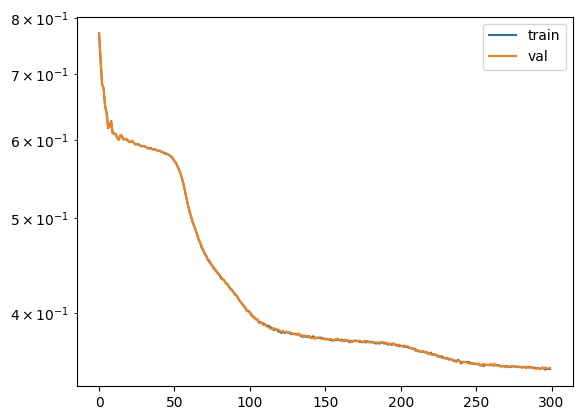

In [583]:
print(train_losses[-1])
pd.DataFrame({
    'train': train_losses,
    'val': val_losses,
}).plot.line(logy=True);

In [584]:
# k_core = 19
# embedding_dim = 32
# num_layers = 3
# max_epochs = 300

m.eval()
with torch.no_grad():
  for d in [train_data, val_data, test_data]:
    pos_edges = d.edge_index
    node_index, positive_track_index, negative_track_index = structured_negative_sampling(d.edge_index)
    neg_edges = torch.stack([node_index, negative_track_index], dim=0)
    all_edges = torch.cat([pos_edges, neg_edges], axis=1)
    src, dst = m(all_edges)
    p = (src * dst).sum(dim=-1).sigmoid()
    print('pos loss value:', float((src[:pos_edges.shape[1]] * dst[:pos_edges.shape[1]]).sum(dim=-1).mean()))
    print('neg loss value:', float((src[-neg_edges.shape[1]:] * dst[-neg_edges.shape[1]:]).sum(dim=-1).mean()))
    print('loss value:', float((src * dst).sum(dim=-1).mean()))
    print('length:', float(torch.cat([(src * src).sum(dim=-1),(dst * dst).sum(dim=-1)], dim=0).mean()))
    print('roc auc score:', sk.metrics.roc_auc_score([1] * pos_edges.shape[1] + [0] * neg_edges.shape[1], p))
    print(sk.metrics.classification_report([True] * pos_edges.shape[1] + [False] * neg_edges.shape[1], p >= .5))

pos loss value: 1.2327536344528198
neg loss value: -0.011112694628536701
loss value: 0.610820472240448
length: 1.589476227760315
roc auc score: 0.9311611674439103
              precision    recall  f1-score   support

       False       0.97      0.55      0.70    172460
        True       0.69      0.99      0.81    172460

    accuracy                           0.77    344920
   macro avg       0.83      0.77      0.75    344920
weighted avg       0.83      0.77      0.75    344920

pos loss value: 1.2336978912353516
neg loss value: -0.01260021049529314
loss value: 0.6105489134788513
length: 1.5907001495361328
roc auc score: 0.9321875453602486
              precision    recall  f1-score   support

       False       0.97      0.55      0.70    172460
        True       0.69      0.99      0.81    172460

    accuracy                           0.77    344920
   macro avg       0.83      0.77      0.75    344920
weighted avg       0.83      0.77      0.75    344920

pos loss value: 1.2

In [580]:
# k_core = 19
# embedding_dim = 32
# num_layers = 1
# max_epochs = 300

m.eval()
with torch.no_grad():
  for d in [train_data, val_data, test_data]:
    pos_edges = d.edge_index
    node_index, positive_track_index, negative_track_index = structured_negative_sampling(d.edge_index)
    neg_edges = torch.stack([node_index, negative_track_index], dim=0)
    all_edges = torch.cat([pos_edges, neg_edges], axis=1)
    src, dst = m(all_edges)
    p = (src * dst).sum(dim=-1).sigmoid()
    print('pos loss value:', float((src[:pos_edges.shape[1]] * dst[:pos_edges.shape[1]]).sum(dim=-1).mean()))
    print('neg loss value:', float((src[-neg_edges.shape[1]:] * dst[-neg_edges.shape[1]:]).sum(dim=-1).mean()))
    print('loss value:', float((src * dst).sum(dim=-1).mean()))
    print('length:', float(torch.cat([(src * src).sum(dim=-1),(dst * dst).sum(dim=-1)], dim=0).mean()))
    print('roc auc score:', sk.metrics.roc_auc_score([1] * pos_edges.shape[1] + [0] * neg_edges.shape[1], p))
    print(sk.metrics.classification_report([True] * pos_edges.shape[1] + [False] * neg_edges.shape[1], p >= .5))

pos loss value: 1.2220377922058105
neg loss value: -0.014159683138132095
loss value: 0.6039391160011292
length: 1.5964651107788086
roc auc score: 0.9378065409376005
              precision    recall  f1-score   support

       False       0.98      0.56      0.71    172460
        True       0.69      0.99      0.81    172460

    accuracy                           0.77    344920
   macro avg       0.84      0.77      0.76    344920
weighted avg       0.84      0.77      0.76    344920

pos loss value: 1.2230125665664673
neg loss value: -0.015605158172547817
loss value: 0.6037037372589111
length: 1.5979833602905273
roc auc score: 0.9378900210768101
              precision    recall  f1-score   support

       False       0.98      0.56      0.71    172460
        True       0.69      0.99      0.81    172460

    accuracy                           0.78    344920
   macro avg       0.84      0.78      0.76    344920
weighted avg       0.84      0.78      0.76    344920

pos loss value: 